# **Cell 1: Installations and Imports**

In [1]:
!pip install ultralytics roboflow supervision opencv-python matplotlib seaborn kaggle -q

import torch
import cv2
import supervision as sv
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import json
import time
from datetime import datetime, timedelta
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")
print(f"🐍 PyTorch version: {torch.__version__}")
print(f"💻 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎯 GPU: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 84.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ All packages imported successfully!
🐍 PyTorch version: 2.8.0+cu126
💻 CUDA available: True
🎯 GPU: Tesla T4


# **Cell 2: Upload kaggle.json and Setup Dataset**

In [2]:
from google.colab import files
import zipfile

def setup_kaggle_and_dataset():
    """Upload kaggle.json and download WIDER FACE dataset"""

    print("📤 Step 1: Please upload your kaggle.json file...")
    uploaded = files.upload()

    if 'kaggle.json' not in uploaded:
        print("❌ kaggle.json not found! Please upload the file.")
        return None

    # Setup Kaggle API
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("✅ Kaggle API configured successfully!")

    # Download dataset
    print("📥 Step 2: Downloading WIDER FACE Dataset...")
    !mkdir -p /content/dataset
    !kaggle datasets download -d jjunnnnn/widerface-dataset-yolov12 -p /content/dataset/

    # Extract dataset
    print("📦 Step 3: Extracting dataset...")
    with zipfile.ZipFile('/content/dataset/widerface-dataset-yolov12.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/dataset/')

    # Set dataset paths
    DATASET_BASE = "/content/dataset/WIDER Face Dataset For YOLOv12/WIDER Face Dataset For YOLOv12"
    TRAIN_IMAGES = f"{DATASET_BASE}/train/images"
    VAL_IMAGES = f"{DATASET_BASE}/val/images"
    TRAIN_LABELS = f"{DATASET_BASE}/train/labels"
    VAL_LABELS = f"{DATASET_BASE}/val/labels"

    print("🔍 Verifying dataset structure...")
    paths = {
        'Base': DATASET_BASE,
        'Train Images': TRAIN_IMAGES,
        'Val Images': VAL_IMAGES,
        'Train Labels': TRAIN_LABELS,
        'Val Labels': VAL_LABELS
    }

    for name, path in paths.items():
        exists = os.path.exists(path)
        print(f"{'✅' if exists else '❌'} {name}: {exists}")

    # Create data.yaml
    data_yaml = f"""
train: {TRAIN_IMAGES}
val: {VAL_IMAGES}
nc: 1
names: ['face']
"""

    with open('/content/data.yaml', 'w') as f:
        f.write(data_yaml)

    print("✅ data.yaml created successfully!")

    return {
        'base': DATASET_BASE,
        'train_images': TRAIN_IMAGES,
        'val_images': VAL_IMAGES,
        'train_labels': TRAIN_LABELS,
        'val_labels': VAL_LABELS
    }

# Setup dataset
dataset_paths = setup_kaggle_and_dataset()

📤 Step 1: Please upload your kaggle.json file...


Saving kaggle.json to kaggle.json
✅ Kaggle API configured successfully!
📥 Step 2: Downloading WIDER FACE Dataset...
Dataset URL: https://www.kaggle.com/datasets/jjunnnnn/widerface-dataset-yolov12
License(s): unknown
100% 3.43G/3.43G [00:42<00:00, 258MB/s]
100% 3.43G/3.43G [00:42<00:00, 86.8MB/s]
📦 Step 3: Extracting dataset...
🔍 Verifying dataset structure...
✅ Base: True
✅ Train Images: True
✅ Val Images: True
✅ Train Labels: True
✅ Val Labels: True
✅ data.yaml created successfully!


# **Cell 3: Dataset Exploration and Visualization**

📊 DATASET EXPLORATION
📸 Training Images: 12,880
📸 Validation Images: 3,226
🏷️ Training Labels: 12,880
🏷️ Validation Labels: 3,226
👥 Faces in train (sample): 5375
👥 Faces in val (sample): 5849
📈 Avg faces per image (train): 10.75
📈 Avg faces per image (val): 11.70

🖼️ Visualizing Dataset Samples...


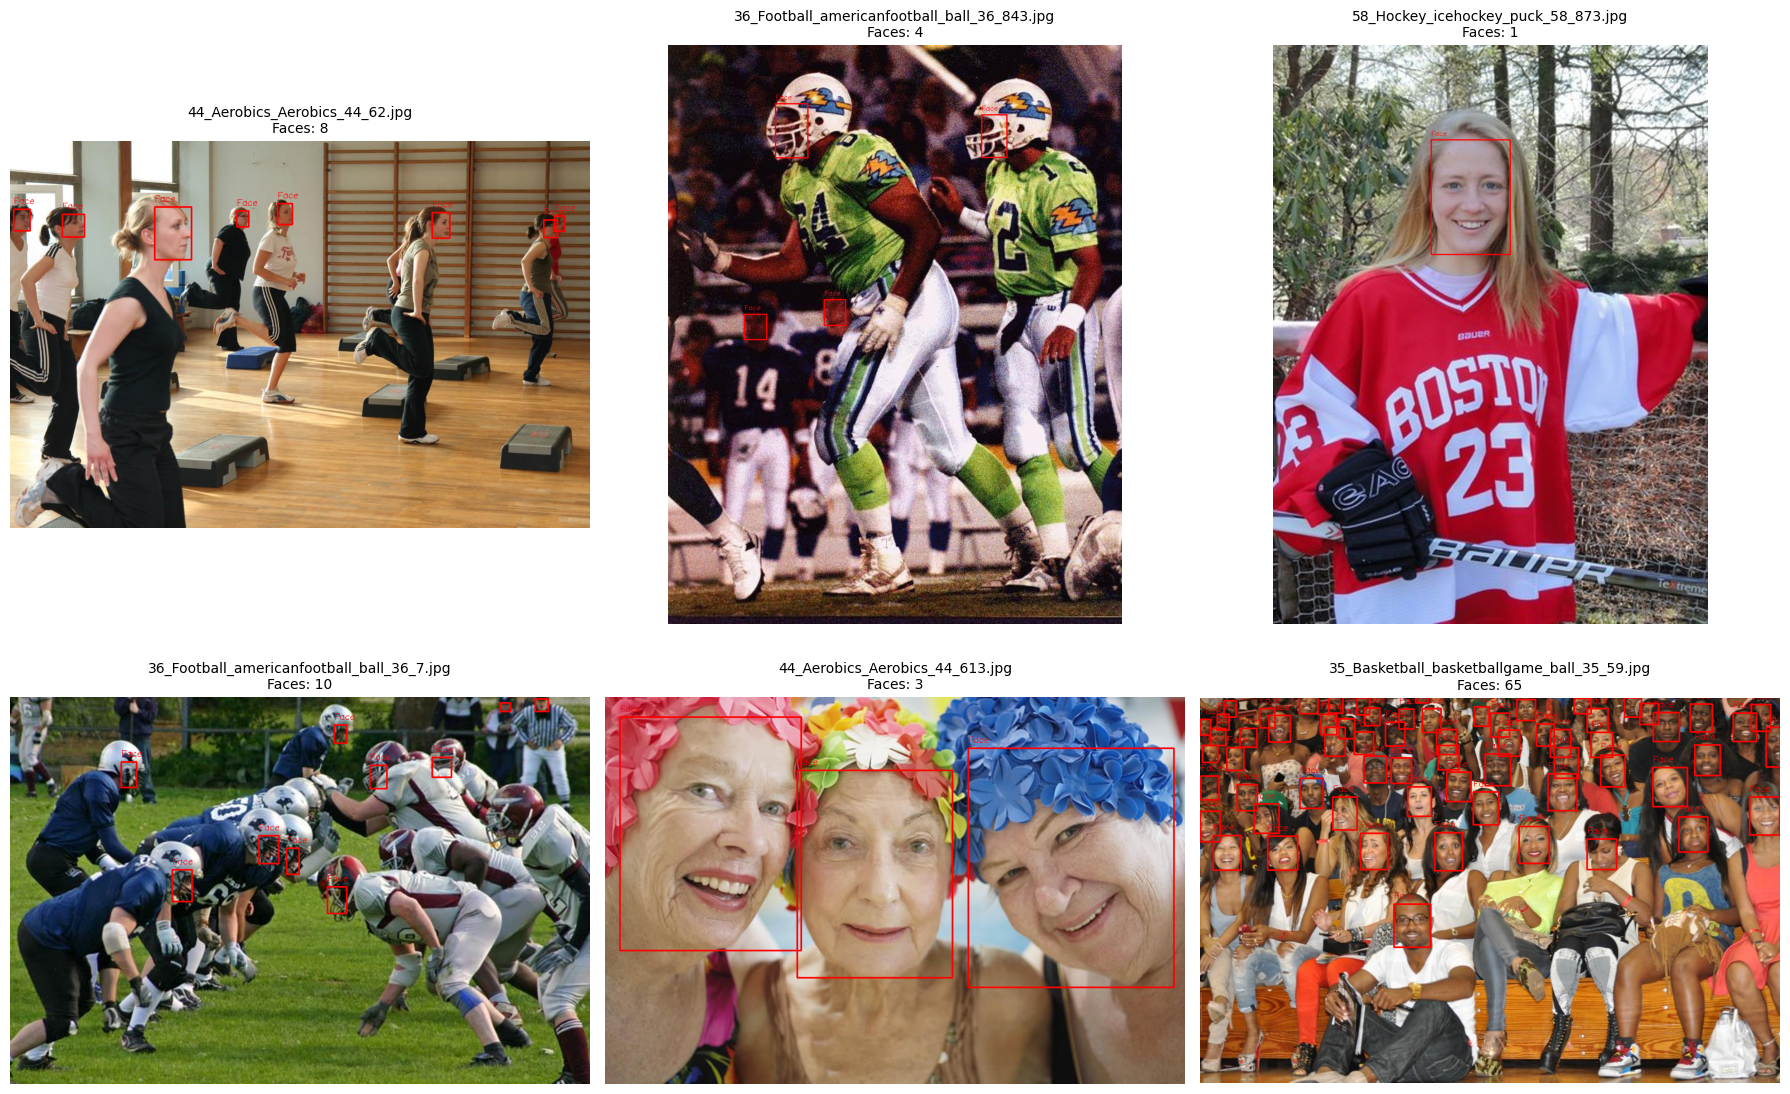

In [3]:
def explore_dataset(dataset_paths):
    """Explore and visualize the dataset"""

    print("📊 DATASET EXPLORATION")
    print("=" * 50)

    # Count files
    train_images = list(Path(dataset_paths['train_images']).glob("*.jpg"))
    val_images = list(Path(dataset_paths['val_images']).glob("*.jpg"))
    train_labels = list(Path(dataset_paths['train_labels']).glob("*.txt"))
    val_labels = list(Path(dataset_paths['val_labels']).glob("*.txt"))

    print(f"📸 Training Images: {len(train_images):,}")
    print(f"📸 Validation Images: {len(val_images):,}")
    print(f"🏷️ Training Labels: {len(train_labels):,}")
    print(f"🏷️ Validation Labels: {len(val_labels):,}")

    # Analyze sample labels
    def count_faces(label_files, sample_size=500):
        total_faces = 0
        for label_file in label_files[:sample_size]:
            try:
                with open(label_file, 'r') as f:
                    total_faces += len([line for line in f.readlines() if line.strip()])
            except:
                continue
        return total_faces

    train_faces = count_faces(train_labels)
    val_faces = count_faces(val_labels)

    print(f"👥 Faces in train (sample): {train_faces}")
    print(f"👥 Faces in val (sample): {val_faces}")
    print(f"📈 Avg faces per image (train): {train_faces/500:.2f}")
    print(f"📈 Avg faces per image (val): {val_faces/500:.2f}")

    # Visualize samples
    print("\n🖼️ Visualizing Dataset Samples...")
    visualize_samples(dataset_paths['train_images'], dataset_paths['train_labels'])

    return len(train_images), len(val_images)

def visualize_samples(images_path, labels_path, num_samples=6):
    """Visualize random samples with bounding boxes"""

    image_files = list(Path(images_path).glob("*.jpg"))
    selected_images = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for idx, img_path in enumerate(selected_images):
        # Load image
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Load labels
        label_path = Path(labels_path) / f"{img_path.stem}.txt"
        face_count = 0

        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    data = line.strip().split()
                    if len(data) == 5:
                        class_id, x_center, y_center, bbox_w, bbox_h = map(float, data)

                        # Convert to pixel coordinates
                        x1 = int((x_center - bbox_w/2) * w)
                        y1 = int((y_center - bbox_h/2) * h)
                        x2 = int((x_center + bbox_w/2) * w)
                        y2 = int((y_center + bbox_h/2) * h)

                        # Draw bounding box
                        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(image, 'Face', (x1, y1-10),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
                        face_count += 1

        axes[idx].imshow(image)
        axes[idx].set_title(f'{img_path.name}\nFaces: {face_count}', fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Explore dataset
if dataset_paths:
    train_count, val_count = explore_dataset(dataset_paths)

# **Cell 4: Fast YOLO Training with Early Stopping**

In [4]:
def train_fast_yolo():
    """Fast YOLO training optimized for Google Colab"""

    print("🚀 FAST YOLO TRAINING")
    print("=" * 50)

    # Load model
    model = YOLO('yolov8n.pt')
    print("✅ Using YOLOv8n for fast training")

    # Optimized training configuration for Colab
    training_config = {
        'data': '/content/data.yaml',
        'epochs': 30,  # Reduced for Colab
        'imgsz': 640,
        'batch': 16,
        'workers': 2,
        'lr0': 0.01,
        'patience': 10,  # Early stopping
        'save': True,
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'project': '/content',
        'name': 'fast_face_detection',
        'amp': True,  # Mixed precision for speed
        'optimizer': 'auto',
        'val': True,
        'verbose': True
    }

    print("📊 Training Configuration:")
    for key, value in training_config.items():
        print(f"  {key}: {value}")

    print(f"\n📈 Dataset Size:")
    print(f"  Train: {train_count:,} images")
    print(f"  Val: {val_count:,} images")

    print("\n🔥 Starting training...")
    start_time = time.time()

    # Train model
    results = model.train(**training_config)

    training_time = time.time() - start_time
    print(f"✅ Training completed in {training_time/60:.1f} minutes")

    return model, results

# Start training
trained_model, training_results = train_fast_yolo()

🚀 FAST YOLO TRAINING
✅ Using YOLOv8n for fast training
📊 Training Configuration:
  data: /content/data.yaml
  epochs: 30
  imgsz: 640
  batch: 16
  workers: 2
  lr0: 0.01
  patience: 10
  save: True
  device: 0
  project: /content
  name: fast_face_detection
  amp: True
  optimizer: auto
  val: True
  verbose: True

📈 Dataset Size:
  Train: 12,880 images
  Val: 3,226 images

🔥 Starting training...
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=Fals

# **Cell 5: Model Validation and Testing**

🔍 MODEL VALIDATION AND TESTING
📊 Running validation...
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2398.7±990.3 MB/s, size: 112.4 KB)
val: Scanning /content/dataset/WIDER Face Dataset For YOLOv12/WIDER Face Dataset For YOLOv12/val/labels.cache... 3226 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3226/3226 4.5Mit/s 0.0s
val: /content/dataset/WIDER Face Dataset For YOLOv12/WIDER Face Dataset For YOLOv12/val/images/21_Festival_Festival_21_604.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 202/202 6.2it/s 32.7s
                   all       3226      39707      0.964      0.448      0.712       0.47
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/runs/detect/val

🎯 VA

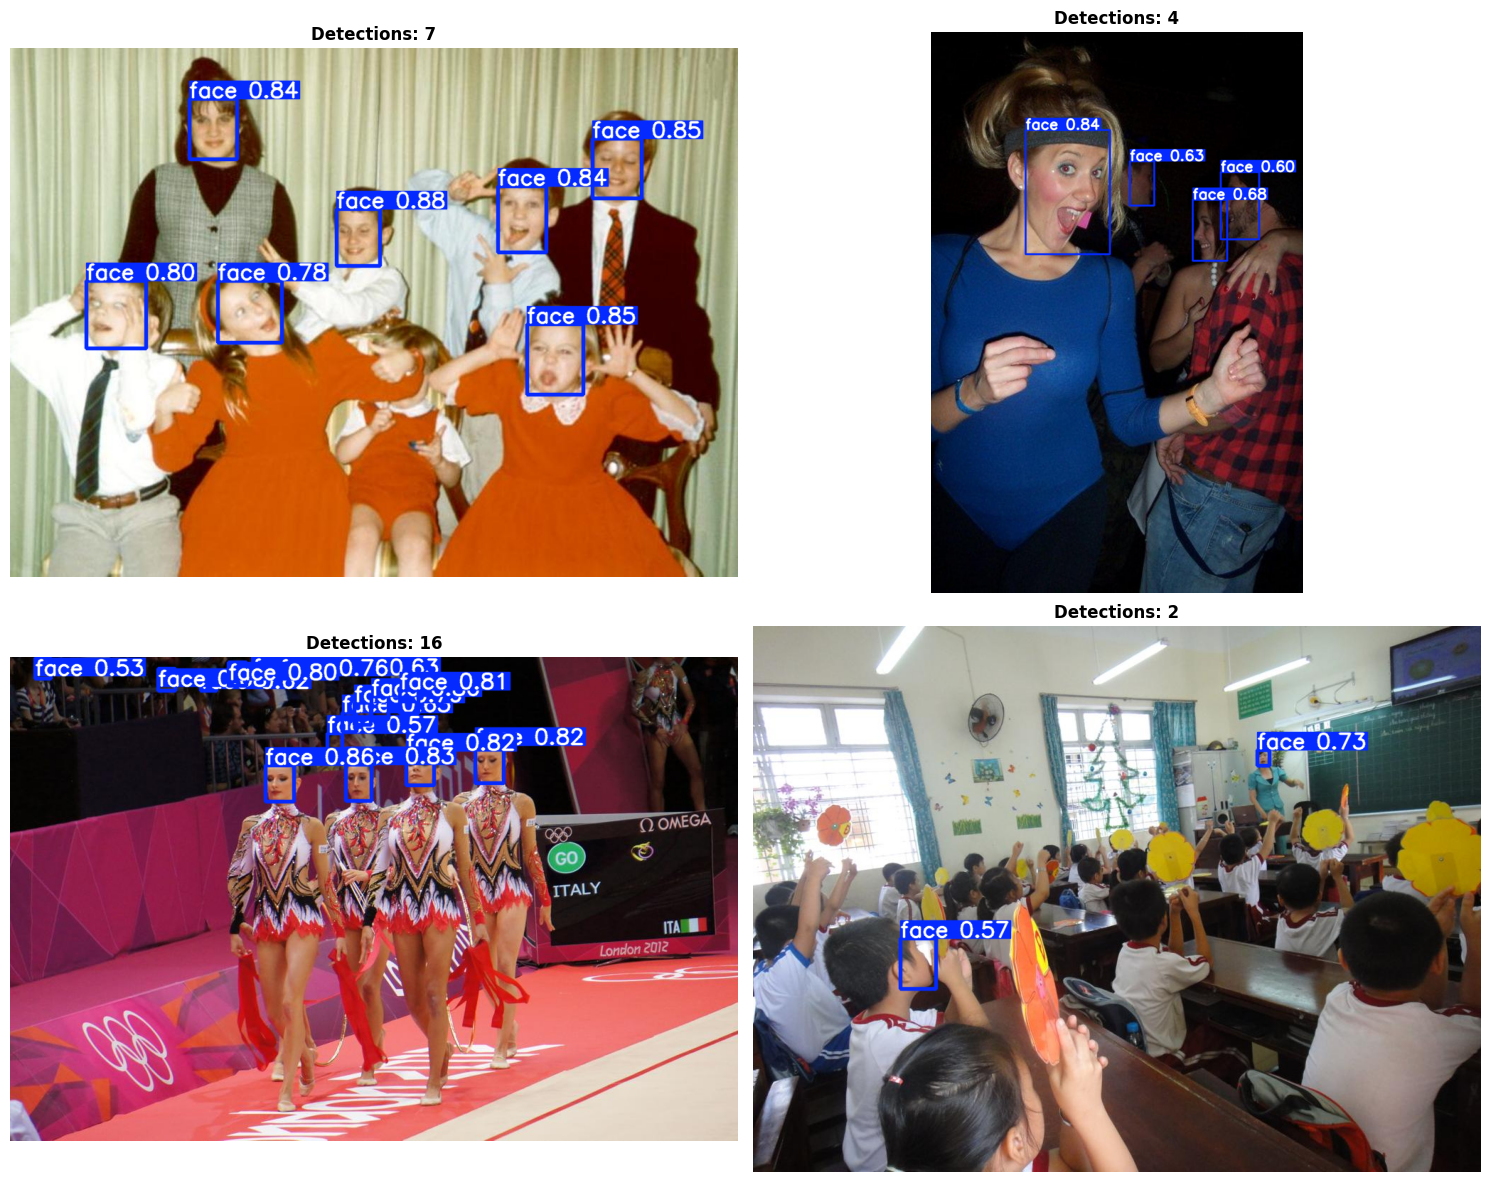

In [5]:
def validate_and_test_model(model):
    """Validate model and test on sample images"""

    print("🔍 MODEL VALIDATION AND TESTING")
    print("=" * 50)

    # Quick validation
    print("📊 Running validation...")
    metrics = model.val(
        data='/content/data.yaml',
        conf=0.5,
        iou=0.5,
        device=0 if torch.cuda.is_available() else 'cpu',
        verbose=True
    )

    print("\n🎯 VALIDATION RESULTS:")
    print(f"✅ mAP50: {metrics.box.map50:.4f}")
    print(f"✅ mAP50-95: {metrics.box.map:.4f}")
    print(f"✅ Precision: {metrics.box.mp:.4f}")
    print(f"✅ Recall: {metrics.box.mr:.4f}")

    # Test on sample images
    print("\n🧪 Testing on sample images...")
    test_on_samples(model, dataset_paths['val_images'])

    return metrics

def test_on_samples(model, val_images_path, num_samples=4):
    """Test model on sample validation images"""

    val_images = list(Path(val_images_path).glob("*.jpg"))
    sample_images = np.random.choice(val_images, min(num_samples, len(val_images)), replace=False)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for idx, img_path in enumerate(sample_images):
        # Run inference
        results = model(str(img_path), conf=0.5, verbose=False)

        # Plot results
        annotated_img = results[0].plot()
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

        detections = len(results[0].boxes)
        axes[idx].imshow(annotated_img_rgb)
        axes[idx].set_title(f'Detections: {detections}', fontsize=12, weight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Validate and test model
if trained_model is not None:
    validation_metrics = validate_and_test_model(trained_model)